# EXERCICE
L’exercice proposé consiste à caler le modèle prix-temps. Cela suppose de rentrer les formules permettant de calculer d’une part le logarithme népérien de la valeur d’indifférence du temps et d’autre part la transformée de la part de marché du fer.

Il faut ensuite faire la régression sur ces deux vecteurs.

Enfin, il faut faire l’analyse des résultats de l’application du modèle théorique en analysant les résidus (comparaison des parts de marché théoriques fournies par le modèle prix-temps avec les parts de marché observées calculées sur les données disponibles). 

In [71]:
from IPython.display import IFrame
IFrame("Motus #1 Exercice Calage Modèle Prix temps 2020_12_11.pdf", width=1300, height=600)

# Résolution de l'exercice

In [57]:
import pandas as pd
import numpy as np

from scipy.stats import norm, linregress
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [59]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), fontsize=18)

## Lecture des données 

In [35]:
data_tmps = pd.read_csv("temps_parcours.csv", sep=";")
data_prix = pd.read_csv("prix.csv", sep=";")
data_part = pd.read_csv("part_marche.csv", sep=";")

In [36]:
data_tmps

,Ville,TEMPS_SNCF,TEMPS_AIR
0,Bordeaux,242,165
1,Brest,308,170
2,Clermont-Ferrand,266,140
3,Limoges,235,180
4,Lyon,185,170
5,Marseille,319,190
6,Metz/Nancy,225,140
7,Montpellier,319,185
8,Nantes,184,175
9,Nice,451,210


In [37]:
data_prix

,Ville,PRIX_SNCF_1,PRIX_SNCF_2,PRIX_Aerien
0,Bordeaux,62.199199,44.705674,82.609073
1,Brest,72.565732,48.074798,98.597926
2,Clermont-Ferrand,44.964838,30.062946,89.444887
3,Limoges,43.150694,28.767130,98.018620
4,Lyon,64.272506,43.409858,90.024194
5,Marseille,72.902645,50.770096,89.097304
6,Metz/Nancy,39.392826,26.305078,125.825321
7,Montpellier,72.760105,50.666431,92.689002
8,Nantes,57.534259,38.356173,90.371777
9,Nice,84.681618,60.177725,101.957903


In [38]:
data_part

,Ville,PART_SNCF_1,PART_SNCF_2,PART_Aerien
0,Bordeaux,413,1592,1400
1,Brest,67,404,428
2,Clermont-Ferrand,76,353,243
3,Limoges,116,359,70
4,Lyon,2024,3345,710
5,Marseille,253,1069,2700
6,Metz/Nancy,408,838,75
7,Montpellier,144,584,1150
8,Nantes,583,1712,350
9,Nice,105,351,2900


## Transformation des données 

In [39]:
data_prix["PRIX_SNCF_1_2"] = (data_prix["PRIX_SNCF_1"] * data_part["PART_SNCF_1"] + data_prix["PRIX_SNCF_2"] * data_part["PART_SNCF_2"]) / (data_part["PART_SNCF_1"] + data_part["PART_SNCF_2"])

In [40]:
data = pd.concat([data_tmps, data_prix, data_part], axis=1)

In [41]:
data = data.loc[:,~data.columns.duplicated()].copy()

In [42]:
data

,Ville,TEMPS_SNCF,TEMPS_AIR,PRIX_SNCF_1,PRIX_SNCF_2,PRIX_Aerien,PRIX_SNCF_1_2,PART_SNCF_1,PART_SNCF_2,PART_Aerien
0,Bordeaux,242,165,62.199199,44.705674,82.609073,48.309079,413,1592,1400
1,Brest,308,170,72.565732,48.074798,98.597926,51.558646,67,404,428
2,Clermont-Ferrand,266,140,44.964838,30.062946,89.444887,32.702908,76,353,243
3,Limoges,235,180,43.150694,28.767130,98.018620,32.279747,116,359,70
4,Lyon,185,170,64.272506,43.409858,90.024194,51.274637,2024,3345,710
5,Marseille,319,190,72.902645,50.770096,89.097304,55.005750,253,1069,2700
6,Metz/Nancy,225,140,39.392826,26.305078,125.825321,30.590633,408,838,75
7,Montpellier,319,185,72.760105,50.666431,92.689002,55.036608,144,584,1150
8,Nantes,184,175,57.534259,38.356173,90.371777,43.227992,583,1712,350
9,Nice,451,210,84.681618,60.177725,101.957903,65.820069,105,351,2900


## Calcul des valeurs d'indifférence, de son Ln et de la part du marché du ferroviaire

In [43]:
data["hi"] = (data["PRIX_SNCF_1_2"] - data["PRIX_Aerien"]) / (data["TEMPS_AIR"] - data["TEMPS_SNCF"]) * 60
data["Ln(hi)"] = data["hi"].apply(np.log)

In [44]:
data["Ln(hi)"]

0     3.285684
1     3.018074
2     3.296577
3     4.272702
4     5.043414
5     2.763582
6     4.208038
7     2.824901
8     5.750322
9     2.196888
10    2.897444
11    2.722904
12    2.225451
Name: Ln(hi), dtype: float64

In [45]:
data["PART_SNCF"] = (data["PART_SNCF_1"] + data["PART_SNCF_2"]) / (data["PART_SNCF_1"] + data["PART_SNCF_2"] + data["PART_Aerien"])

In [46]:
data["PART_SNCF"]

0     0.588840
1     0.523915
2     0.638393
3     0.871560
4     0.883204
5     0.328692
6     0.943225
7     0.387646
8     0.867675
9     0.135876
10    0.338974
11    0.491790
12    0.220359
Name: PART_SNCF, dtype: float64

In [47]:
data["PHI(PART_SNCF)"] = data["PART_SNCF"].apply(norm.ppf)

## Estimation de la régression linéeaire 

In [48]:
result = linregress(data["Ln(hi)"].values, data["PHI(PART_SNCF)"].values)

In [49]:
print(result.slope, result.intercept)

0.6818354499979745 -2.132233549096914


In [50]:
print(result.pvalue, result.stderr, result.intercept_stderr)

5.8016293455350645e-05 0.10815216617435407 0.38698750780274954


In [51]:
0.6818354499979745+0.95*0.10815216617435407/np.sqrt(12)

0.7114952490687216

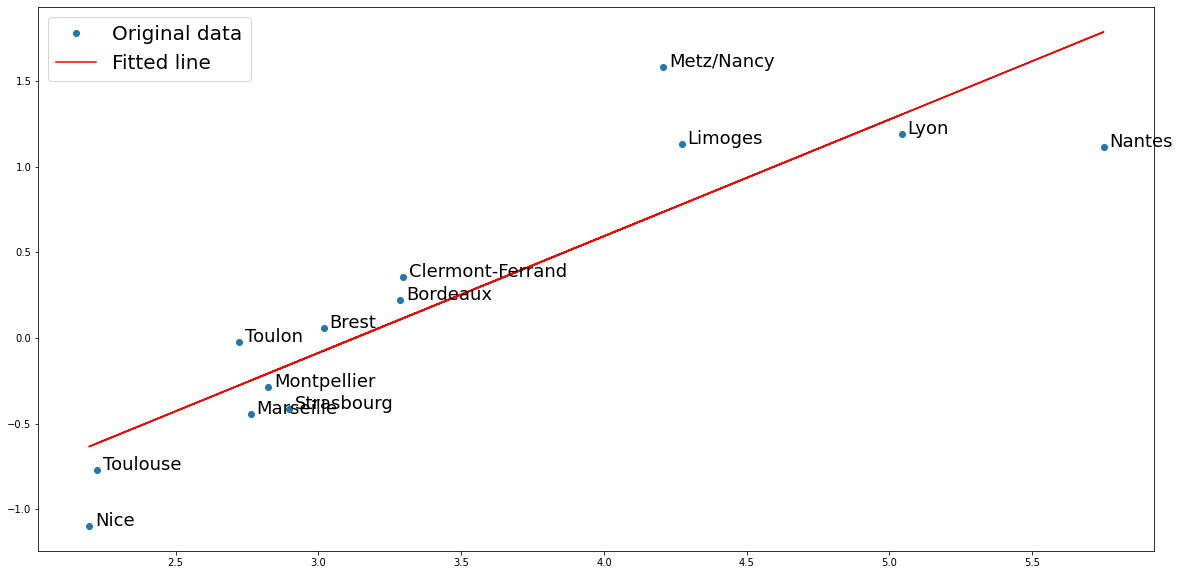

In [65]:
x, y, n = data["Ln(hi)"], data["PHI(PART_SNCF)"], data["Ville"]

ax = plt.plot(x, y, 'o', label='Original data')
label_point(x, y, n, plt.gca())  

plt.plot(x, result.intercept + result.slope*x, 'r', label='Fitted line')

plt.legend(fontsize=20)

In [83]:
data["PART_SNCF_MODEL"] = (result.intercept + result.slope*x).apply(norm.cdf)